Transfer learning of labels from Reyfman et al AJRCCM 2019 (GSE122960) object onto object from Bailey et al. bioRxiv 2023 (GSE232627).

- Subset Reyfman object on IPF samples
- Exclude genes uniquely detected in 3' or 5' chemistry
- exclude meaningless transcripts (see [here](https://www.ncbi.nlm.nih.gov/genbank/acc_prefix/) and [here](https://www.ncbi.nlm.nih.gov/books/NBK21091/table/ch18.T.refseq_accession_numbers_and_mole/?report=objectonly)), mitochondrial genes, and ribosomal genes 

In [1]:
import pathlib
import anndata
import scvi
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import pandas as pd
import numpy as np
import sklearn.neighbors
import pynndescent
import numba
import warnings

/projects/b1038/Pulmonary/ksenkow/Long_COVID/geneformer_env/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/projects/b1038/Pulmonary/ksenkow/Long_COVID/geneformer_env/venv/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/projects/b1038/Pulmonary/ksenkow/Long_COVID/geneformer_env/venv/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [2]:
pd.set_option('display.max_columns', None)

In [3]:
torch.cuda.current_device()

0

### Load reference object - annotated Reyfman processed with b93 + SARS

In [6]:
reference = sc.read_h5ad('../../data/21scArches/reyfman_reprocessed/reyfman_reprocessed.h5ad')

In [7]:
scanvae = scvi.model.SCANVI.load('models/reyfman_on_reyfman_diff_ref_genomes.model', reference)

INFO     File models/reyfman_on_reyfman_diff_ref_genomes.model/model.pt already downloaded                         


/projects/b1038/Pulmonary/ksenkow/Long_COVID/geneformer_env/venv/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /projects/b1038/Pulmonary/ksenkow/Long_COVID/genefo ...
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


### Subset on IPF samples

In [8]:
ipf_samples = reference.obs[reference.obs['sample'].str.startswith('IPF')]['sample'].unique().tolist()

In [9]:
reference = reference[reference.obs['sample'].isin(ipf_samples)]

### Remove epithelial cells from reference
They are not found in PASC object that we are mapping to.

In [10]:
reference = reference[~reference.obs.cell_type_pred.isin(['Secretory cells', 'Basal cells', 'Transitional Club-AT2', 'AT2-2',
                                             'AT2-1', 'AT1'])]

## Remove meaningless genes 
### Remove transcripts with 'AC', 'AP', 'AL', 'AF', etc. prefix from list of genes. Also remove ribosomal genes and mitochondrial genes. Also remove genes unique to 3' chemistry (since PASC dataset was 5' chemistry).
These are "genes" are actually transcripts with prefixes like ACXXXXX, APXXXXXX, and ALXXXXXX. See Biostars note [here](https://www.biostars.org/p/9553891/). Since these are not biologically significant genes, it makes sense to exclude them. However, we don't expect to find them expressed since they are uniquely detected in 3' chemistry.

In [11]:
# specify the prefix pattern
prefixes_to_remove = ['AC', 'AL', 'AP', 'AF', 'AD', 'BX', 'CR', 'FP', 'KF']

# specify tlhe pattern to match genes to remove
pattern_to_remove = '|'.join([f'{prefix}\d{{6}}\.\d' for prefix in prefixes_to_remove] + ['Z\d{5}\.\d', 'U\d{5}\.\d'])

In [12]:
three_p_only = pd.read_csv('../../data/21scArches/unique_genes_chem/three_prime_only.csv', index_col=0)

In [13]:
three_p_only = three_p_only.index.tolist()
# Keep SARS genes
three_p_only = [gene for gene in three_p_only if not gene.startswith("SARS2")]

In [14]:
five_p_only = pd.read_csv('../../data/21scArches/unique_genes_chem/five_prime_only.csv', index_col=0)

In [15]:
five_p_only = five_p_only.index.tolist()
# Keep SARS genes
five_p_only = [gene for gene in five_p_only if not gene.startswith("SARS2")]

In [16]:
# Create boolean masks for both conditions
pattern_mask = reference.raw.var.index.str.contains(pattern_to_remove, regex=True)
ribo_mito_mask = reference.raw.var.index.str.startswith(("RPS", "RPL", "MT-"))
three_p_mask = reference.raw.var.index.isin(three_p_only)
five_p_mask = reference.raw.var.index.isin(five_p_only)

# Create a combined mask 
combined_mask = (pattern_mask | ribo_mito_mask | three_p_mask | five_p_mask)

In [17]:
print(pattern_mask.sum())
print(ribo_mito_mask.sum())
print(three_p_mask.sum())
print(five_p_mask.sum())
print(combined_mask.sum())

7557
115
1788
524
8908


In [19]:
# Create a new AnnData object with the filtered data
reference = anndata.AnnData(
    X=reference.raw.X[:, ~combined_mask],
    obs=reference.obs,
    var=reference.raw.var[~combined_mask],
    obsm=reference.obsm,
    uns=reference.uns
)

In [20]:
reference.layers["counts"] = reference.X.copy()

### Load PASC dataset

In [22]:
PASC = sc.read_h5ad('/projects/b1038/Pulmonary/cpuritz/PASC/data/01BAL/raw/adata_raw_final.h5ad')

### Rename genes to remove GRCh38 prefix

In [23]:
PASC.var['gene_ids'] = PASC.var['gene_ids'].str.replace('GRCh38_', '')

### Remove meaningless genes
Same workflow as above.

In [24]:
# Create boolean masks for both conditions
pattern_mask = PASC.var.index.str.contains(pattern_to_remove, regex=True)
ribo_mito_mask = PASC.var.index.str.startswith(("RPS", "RPL", "MT-"))
three_p_mask = PASC.var.index.isin(three_p_only)
five_p_mask = PASC.var.index.isin(five_p_only)

# Create a combined mask using numpy.logical_or
combined_mask = (pattern_mask | ribo_mito_mask | three_p_mask | five_p_mask)

print(pattern_mask.sum())
print(ribo_mito_mask.sum())
print(three_p_mask.sum())
print(five_p_mask.sum())
print(combined_mask.sum())

12510
116
2480
1150
14377


In [25]:
# Create a new AnnData object with the filtered data
PASC = anndata.AnnData(
    X=PASC.X[:, ~combined_mask],
    obs=PASC.obs,
    var=PASC.var[~combined_mask],
)

In [26]:
PASC.layers["counts"] = PASC.X.copy()

### Save unnormalized raw counts

In [27]:
PASC.write_h5ad('../../data/21scArches/PASC/PASC_raw_unnormalized.h5ad')

In [27]:
sc.pp.normalize_total(PASC, target_sum=1e4)
sc.pp.log1p(PASC)
PASC.raw = PASC # freeze the state in `.raw`

In [28]:
PASC.write_h5ad('../../data/21scArches/PASC/PASC_raw.h5ad')

In [29]:
scanvae.prepare_query_anndata(PASC, scanvae)

INFO     Found 87.25% reference vars in query data.                                                                


/projects/b1038/Pulmonary/ksenkow/Long_COVID/geneformer_env/venv/lib/python3.9/site-packages/anndata/_core/merge.py:1111: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


### Setup and train model

In [30]:
PASC.obs["pred_labels"] = scanvae.unlabeled_category_

In [31]:
PASC.obs['batch'] = (
    PASC.obs['Library_ID'].cat.codes 
    + reference.obs.batch.astype(int).max() 
    + 10
).astype(str).astype('category')

In [32]:
train_kwargs_surgery = {
    "early_stopping": True,
    "early_stopping_monitor": "elbo_train",
    "early_stopping_patience": 10,
    "early_stopping_min_delta": 0.001,
    "plan_kwargs": {"weight_decay": 0.0},
}

In [33]:
model = scvi.model.SCANVI.load_query_data(PASC, scanvae, accelerator='gpu')

/projects/b1038/Pulmonary/ksenkow/Long_COVID/geneformer_env/venv/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /projects/b1038/Pulmonary/ksenkow/Long_COVID/genefo ...
/projects/b1038/Pulmonary/ksenkow/Long_COVID/geneformer_env/venv/lib/python3.9/site-packages/scvi/data/_manager.py:216: UserWarning: Missing labels key ann_level_3. Filling in with unlabeled category Unknown.
  field_registry[_constants._STATE_REGISTRY_KEY] = field.transfer_field(


In [34]:
model.train(max_epochs=500, **train_kwargs_surgery)

INFO     Training for 500 epochs.                                                                                  


/projects/b1038/Pulmonary/ksenkow/Long_COVID/geneformer_env/venv/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /projects/b1038/Pulmonary/ksenkow/Long_COVID/genefo ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/projects/b1038/Pulmonary/ksenkow/Long_COVID/geneformer_env/venv/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /projects/b1038/Pulmonary/ksenkow/Long_COVID/genefo ...
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To proper

Epoch 63/500:  13%|████████████▎                                                                                     | 63/500 [31:15<3:36:47, 29.77s/it, v_num=1, train_loss_step=451, train_loss_epoch=461]
Monitored metric elbo_train did not improve in the last 10 records. Best score: 487.339. Signaling Trainer to stop.


In [36]:
model.save('models/reyfman_on_PASC.model')

In [37]:
model = scanvae.load('models/reyfman_on_PASC.model', PASC)

INFO     File models/reyfman_on_PASC.model/model.pt already downloaded                                             


/projects/b1038/Pulmonary/ksenkow/Long_COVID/geneformer_env/venv/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3 /projects/b1038/Pulmonary/ksenkow/Long_COVID/genefo ...


### Get latent representation of model

In [38]:
PASC.obsm['X_scvi'] = model.get_latent_representation()

In [39]:
sc.pp.neighbors(PASC, use_rep='X_scvi')
sc.tl.umap(PASC, min_dist=0.3)

/projects/b1038/Pulmonary/ksenkow/Long_COVID/geneformer_env/venv/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/projects/b1038/Pulmonary/ksenkow/Long_COVID/geneformer_env/venv/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/projects/b1

In [40]:
sc.tl.leiden(PASC)

/projects/b1038/Pulmonary/ksenkow/Long_COVID/geneformer_env/venv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


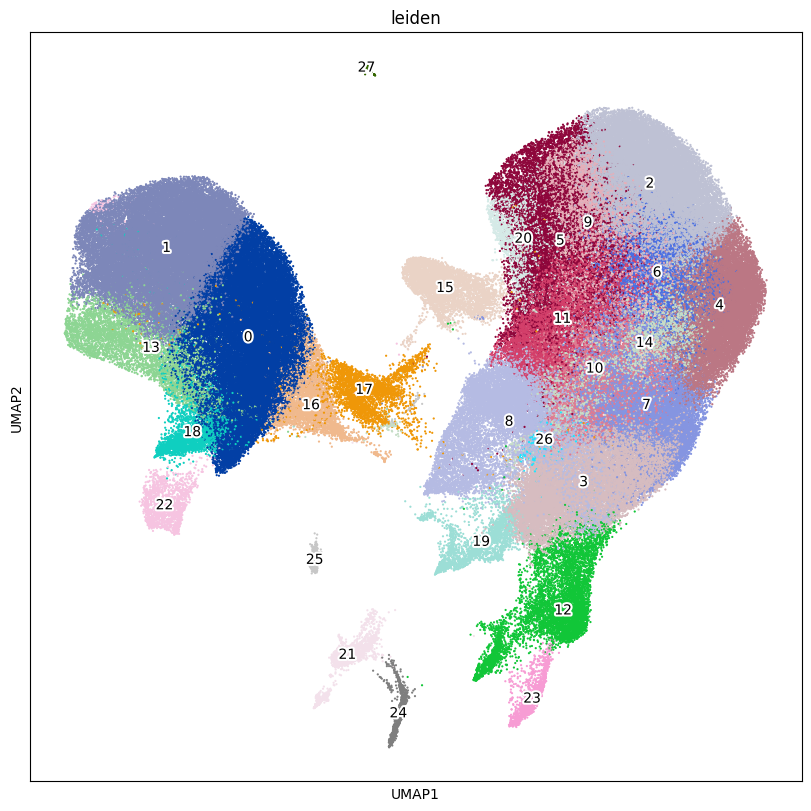

In [41]:
fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True) 
sc.pl.umap(
    PASC, 
    color='leiden', 
    legend_loc='on data', 
    ax=ax, 
    legend_fontweight='normal',
    legend_fontoutline=3,
    size=10
)

<Axes: title={'center': 'total_counts'}, xlabel='UMAP1', ylabel='UMAP2'>

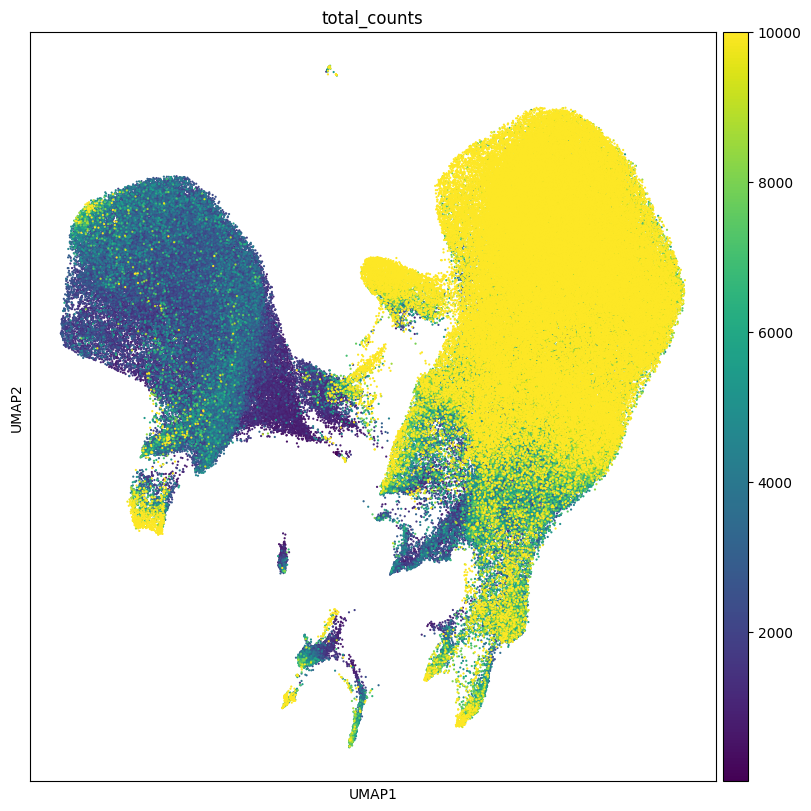

In [42]:
fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)
sc.pl.umap(
    PASC,
    color='total_counts',
    legend_loc='on data',
    legend_fontweight='normal',
    legend_fontoutline=3,
    show=False,
    size=10,
    ax=ax,
    vmax=10000
)

### Get raw object
Raw counts are not preserved. Grab them again.

In [43]:
PASC_raw = sc.read_h5ad('../../data/21scArches/PASC/PASC_raw.h5ad')

In [44]:
PASC.raw = PASC_raw

Code below is from https://docs.scvi-tools.org/en/stable/tutorials/notebooks/scrna/query_hlca_knn.html

In [45]:
reference_nn_index = pynndescent.NNDescent(reference.obsm['X_scvi'])

In [46]:
reference_nn_index.prepare()

In [47]:
ref_neighbors, ref_distances = reference_nn_index.query(PASC.obsm['X_scvi'])

In [48]:
# convert distances to affinities
stds = np.std(ref_distances, axis=1)
stds = (2.0 / stds) ** 2
stds = stds.reshape(-1, 1)
ref_distances_tilda = np.exp(-np.true_divide(ref_distances, stds))
weights = ref_distances_tilda / np.sum(ref_distances_tilda, axis=1, keepdims=True)

In [49]:
@numba.njit
def weighted_prediction(weights, ref_cats):
    """Get highest weight category."""
    N = len(weights)
    predictions = np.zeros((N,), dtype=ref_cats.dtype)
    uncertainty = np.zeros((N,))
    for i in range(N):
        obs_weights = weights[i]
        obs_cats = ref_cats[i]
        best_prob = 0
        for c in np.unique(obs_cats):
            cand_prob = np.sum(obs_weights[obs_cats == c])
            if cand_prob > best_prob:
                best_prob = cand_prob
                predictions[i] = c
                uncertainty[i] = max(1 - best_prob, 0)

    return predictions, uncertainty

In [50]:
ref_cats = reference.obs.cell_type_pred.cat.codes.to_numpy()[ref_neighbors]
p, u = weighted_prediction(weights, ref_cats)
p = np.asarray(reference.obs.cell_type_pred.cat.categories)[p]
PASC.obs["cell_type_pred"], PASC.obs["cell_type_uncertainty"] = p, u

/projects/b1038/Pulmonary/ksenkow/Long_COVID/geneformer_env/venv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


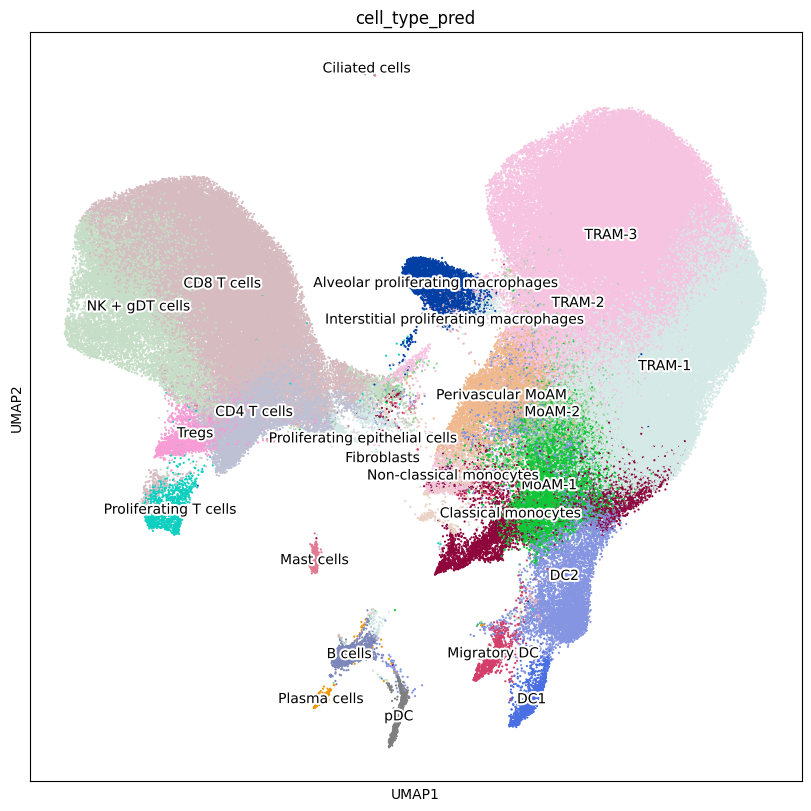

In [51]:
fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True) 
sc.pl.umap(
    PASC, 
    color='cell_type_pred', 
    legend_loc='on data', 
    ax=ax, 
    legend_fontweight='normal',
    legend_fontoutline=3,
    size=10
)

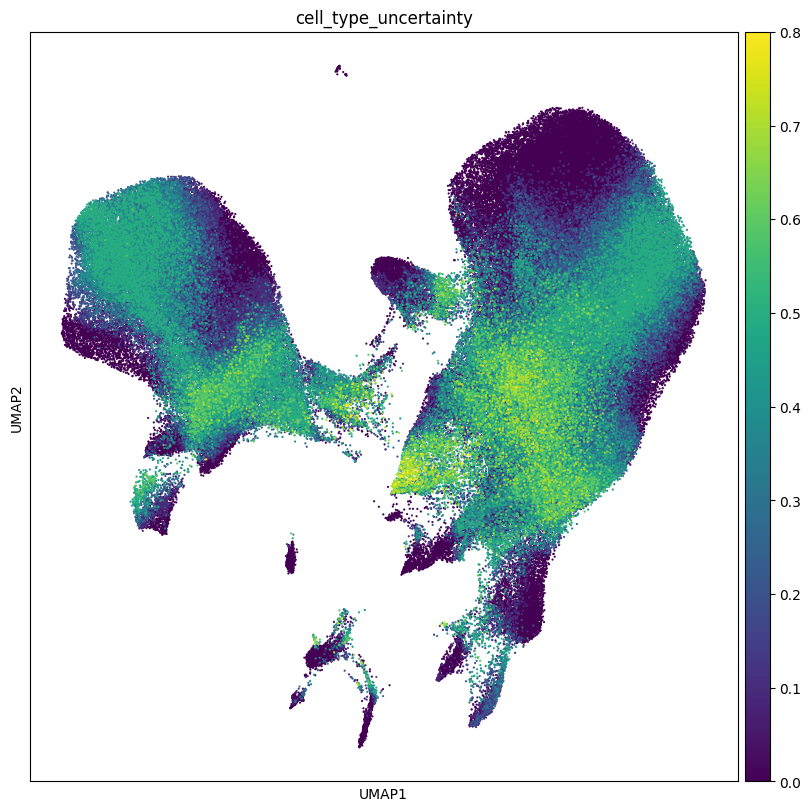

In [52]:
fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True) 
sc.pl.umap(
    PASC, 
    color='cell_type_uncertainty', 
    legend_loc='on data', 
    ax=ax, 
    legend_fontweight='normal',
    legend_fontoutline=3,
    size=10
)

### Get markers

In [53]:
def get_markers(
    adata,
    groupby,
    key="rank_genes_groups",
    p_val_cutoff=0.05,
    logfc_cutoff=0.5
):
    """\
    Extract markers from adata into Seurat-like table

    Extracts markers after they are computed by ``scanpy``. Produces Seurat-like
    table with fields
    ``"p_val", "avg_logFC", "pct.1", "pct.2", "p_val_adj", "cluster", "gene"``

    Calculates the percentage of cells that express a given gene
    in the target cluster (``pct.1`` field) and outside the cluster
    (``pct.2`` field) from ``adata.raw`` matrix.

    Parameters
    ----------
    adata
        Annotated data matrix.
    groupby
        ``adata.obs`` field used for marker calculation
    key
        ``adata.uns`` key that has computed markers
    p_val_cutoff
        Drop all genes with adjusted p-value greater than or equal to this
    logfc_cutoff
        Drop all genes with average logFC less than or equal to this

    Returns
    -------
    Returns a pandas dataframe with above listed columns, optionally
    subsetted on the genes that pass the cutoffs.
    ``p_val`` field is a copy of adjusted p-value field.

    Example
    -------
    >>> sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon", n_genes=200)
    >>> markers = sc_utils.get_markers(adata, "leiden")
    >>> markers.to_csv("markers.csv")
    """
    markers = pd.concat([
        pd.DataFrame(adata.uns[key]["names"]).melt(),
        pd.DataFrame(adata.uns[key]["pvals_adj"]).melt(),
        pd.DataFrame(adata.uns[key]["logfoldchanges"]).melt()
    ], axis=1)
    markers.columns = ("cluster", "gene", "cluster2", "p_val_adj", "cluster3", "avg_logFC")
    markers = markers.loc[:, ["cluster", "gene", "avg_logFC", "p_val_adj"]]
    markers = markers.loc[markers.avg_logFC > logfc_cutoff, ]
    markers = markers.loc[markers.p_val_adj < p_val_cutoff, ]
    markers["pct.1"] = pd.Series(dtype=float)
    markers["pct.2"] = pd.Series(dtype=float)

    for cluster in markers.cluster.unique():
        cells = adata.obs[groupby] == cluster
        in_cluster_selector = markers.cluster == cluster
        genes = markers.gene[in_cluster_selector]
        in_cluster = np.sum(adata.raw[cells, genes].X > 0, axis=0).A1 / cells.sum()
        markers.loc[in_cluster_selector, "pct.1"] = in_cluster
        other_cells = adata.obs[groupby] != cluster
        other_clusters = np.sum(adata.raw[other_cells, genes].X > 0, axis=0).A1 / other_cells.sum()
        markers.loc[in_cluster_selector, "pct.2"] = other_clusters

    markers["p_val"] = markers.p_val_adj
    markers = markers.loc[:, ["p_val", "avg_logFC", "pct.1", "pct.2", "p_val_adj", "cluster", "gene"]]
    return markers

In [54]:
PASC.obs.cell_type_pred.value_counts()

cell_type_pred
TRAM-3                                    77890
CD8 T cells                               45712
TRAM-1                                    45289
NK + gDT cells                            14159
MoAM-1                                     9985
CD4 T cells                                9449
DC2                                        7711
Perivascular MoAM                          6513
Classical monocytes                        4820
MoAM-2                                     4178
Alveolar proliferating macrophages         3661
Tregs                                      2632
B cells                                    1540
Proliferating T cells                      1511
DC1                                        1359
Migratory DC                               1156
Non-classical monocytes                     993
TRAM-2                                      867
pDC                                         767
Mast cells                                  490
Plasma cells             

In [55]:
PASC_backup = PASC.copy()

### Remove fibroblasts and proliferating epithelial cells - too few cells

In [60]:
PASC = PASC[~PASC.obs.cell_type_pred.isin(["Fibroblasts", "Proliferating epithelial cells"])]

In [61]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    sc.tl.rank_genes_groups(PASC, "cell_type_pred", method="t-test", n_genes=200)

In [62]:
markers = get_markers(PASC, "cell_type_pred")

In [63]:
markers.sort_values(["cluster", "avg_logFC"], ascending=[True, False], inplace=True)

In [64]:
markers.groupby("cluster").head(2)

,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
183,0.000000e+00,7.806313,0.504507,0.002742,0.000000e+00,Alveolar proliferating macrophages,KIF20A
67,0.000000e+00,7.686951,0.687790,0.005842,0.000000e+00,Alveolar proliferating macrophages,ANLN
200,0.000000e+00,12.436602,0.934416,0.001959,0.000000e+00,B cells,MS4A1
201,0.000000e+00,10.790161,0.855844,0.003398,0.000000e+00,B cells,CD79A
500,2.812912e-277,5.273081,0.140544,0.005876,2.812912e-277,CD4 T cells,MAL
533,8.546539e-228,4.483286,0.121389,0.007380,8.546539e-228,CD4 T cells,FBLN7
601,0.000000e+00,6.699718,0.921749,0.107084,0.000000e+00,CD8 T cells,CCL5
600,0.000000e+00,5.677284,0.939491,0.151273,0.000000e+00,CD8 T cells,IL32
804,1.166561e-34,15.418927,0.894737,0.000112,1.166561e-34,Ciliated cells,CHST9
817,2.645151e-29,15.358591,0.831579,0.000108,2.645151e-29,Ciliated cells,LRRIQ1


### Save
Fill in NA values in var with 0s and False

I assume that NA values stem from differences in genes between reference genomes.

In [65]:
PASC.var

,gene_ids,feature_types,mito,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
SAMD11,ENSG00000187634,Gene Expression,False,43.0,0.000211,99.982190,51.0
ISG15,ENSG00000187608,Gene Expression,False,123129.0,1.763298,49.000969,425720.0
TTLL10,ENSG00000162571,Gene Expression,False,699.0,0.003135,99.710480,757.0
TNFRSF18,ENSG00000186891,Gene Expression,False,8795.0,0.071730,96.357183,17318.0
TNFRSF4,ENSG00000186827,Gene Expression,False,8061.0,0.087088,96.661199,21026.0
...,...,...,...,...,...,...,...
COL6A1,ENSG00000142156,Gene Expression,False,3820.0,0.020855,98.417787,5035.0
COL6A2,ENSG00000142173,Gene Expression,False,1718.0,0.010574,99.288418,2553.0
C21orf58,ENSG00000160298,Gene Expression,False,3970.0,0.019674,98.355658,4750.0
S100B,ENSG00000160307,Gene Expression,False,9687.0,0.201587,95.987723,48670.0


In [66]:
bool_columns = ['mito']
PASC.var[bool_columns] = PASC.var[bool_columns].fillna(False)

In [67]:
PASC.write_h5ad('../../data/21scArches/reyfman_on_PASC/reyfman_on_PASC.h5ad')

In [68]:
markers.to_csv('../../data/21scArches/reyfman_on_PASC/reyfman_on_PASC-markers.csv')

In [69]:
PASC.obs.to_csv('../../data/21scArches/reyfman_on_PASC/reyfman_on_PASC-metadata.csv')